# Deep Portfolio Theory - analyze the ability of a Neural Network based approach to uncover market factors
### Data
Synthetic data and S&P 500 daily returns data.

###  Objective
Compare PCA and Neural Networks in their ability to uncover market factors, and apply to portfolio construction.

1. Generate synthetic stock return data with one market factor and autoregressive residuals. Then use PCA the uncover and estimate mean reversion and volatility of residuals.
2. Try to uncover the factors and the residuals using the Deep Learning approach.
3. Do the analysis with the S&P 500 data. You may want to add technical indicators as additional predictors.

### Literatures
1. J. Yeo and G. Papanicolaou, “Random Matrix Approach to Estimation of High-Dimensional Factor Models” (2016) (https://arxiv.org/pdf/1611.05571.pdf)
2. J. Heaton, N. Polson, J. Witte, “Deep Portfolio Theory”
https://arxiv.org/abs/1605.07230
3. N. Polson and V. Sokolov, “Deep Learning: a Bayesian Perspective” (2017) https://arxiv.org/abs/1706.00473
4. L.Troiano, E. Mejuto, and P. Kriplani, “On Feature Reduction using Deep Learning for Trend Prediction in Finance” (2016) https://arxiv.org/abs/1704.03205

In [1]:
# all the imports
import matplotlib.pyplot as plt
import numpy as np
np.warnings.filterwarnings("ignore")

import scipy
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.compat.v1 as tf
from tensorflow.python.framework import ops
from tensorflow.python.layers import core as core_layers
import pandas as pd
from datetime import datetime
import time
import pytz
import talib
from talib import MA_Type
import pandas_datareader.data as web
from sklearn import metrics

from numpy.random import seed
from scipy.stats import norm
import scipy.stats as stats
from scipy.linalg import sqrtm

from sklearn import datasets,metrics, linear_model, svm
from sklearn import preprocessing as prep
from sklearn.decomposition import PCA
import statsmodels.api as sm

ops.reset_default_graph()

tf.disable_v2_behavior()

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
warnings.filterwarnings(action="ignore", module="pandas")

# utility function to reset the TF graph to the same state each time
def reset_graph():
    tf.reset_default_graph()
    tf.set_random_seed(42)
    np.random.seed(42)

Instructions for updating:
non-resource variables are not supported in the long term


## Do the analysis with the 600716 data.
We downloaded 600716 data with pandas.dataframe structure.

We add technical indicators as additional predictors. We employed Talib package to do th ecalculation and the data was saved to a csv file to make sure everything has the access to these dataframe.

In [2]:
fhgf = pd.read_csv("/Users/Elizabeth.Ke.Zhang/Desktop/stock_analysis/StockDir/凤凰股份600716.ss.csv")
print(fhgf.shape)
fhgf.head(5)

(2401, 7)


,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-01-04,9.68,9.51,9.59,9.58,3933500.0,8.945965
1,2010-01-05,9.99,9.56,9.73,9.66,6134797.0,9.020670
2,2010-01-06,9.69,9.44,9.57,9.45,6401929.0,8.824568
3,2010-01-07,9.58,9.31,9.50,9.38,4601650.0,8.759202
4,2010-01-08,9.54,9.29,9.41,9.54,4047412.0,8.908611


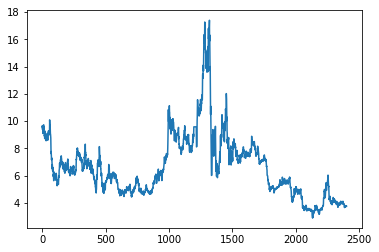

In [3]:
plt.plot(fhgf['Close'])
plt.show()

In [4]:
open = fhgf["Open"]
high = fhgf["High"]
low = fhgf["Low"]
close = fhgf["Close"]
adj_close = fhgf["Adj Close"]
volume = fhgf["Volume"]
R = np.diff(np.log(adj_close.values))
r = np.sign(R)

# Creating Momentum variables
fhgf["ADX"] = talib.ADX(high, low, close, timeperiod = 10)
fhgf['AROONDOWN'] = talib.AROON(high, low, timeperiod = 10)[0]
fhgf['AROONUP'] = talib.AROON(high, low,timeperiod = 10)[1]
fhgf["AROONOSC"] = talib.AROONOSC(high, low, timeperiod = 10)
fhgf["BOP"] = talib.BOP(open, high, low, close)
fhgf["CCI"] = talib.CCI(high, low, close, timeperiod = 10)
fhgf["CMO"] = talib.CMO(close, timeperiod = 10)
fhgf["MFI"] = talib.MFI(high, low, close, volume, timeperiod = 10)
fhgf["PPO"] = talib.PPO(close, fastperiod = 10, slowperiod = 20, matype=0)
fhgf["ROC"] = talib.ROC(close, timeperiod = 10)
fhgf["RSI"] = talib.RSI(close, timeperiod = 10)
fhgf["TRIX"] = talib.TRIX(close, timeperiod=10)
fhgf["ULTOSC"] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Creating Overlap variables
# fhgf["MAMA"] = talib.MAMA(close, fastlimit=0, slowlimit=0)[0]
fhgf["SAR"] = talib.SAR(high, low, maximum=3)
fhgf["TEMA"] = talib.TEMA(close, timeperiod = 10)
fhgf["TRIMA"] = talib.TRIMA(close, timeperiod = 10)
fhgf["WMA"] = talib.WMA(close, timeperiod=3)

# Creating Volume variables
fhgf["ADOSC"] = talib.ADOSC(high, low, close, volume, fastperiod=5, slowperiod=10)
fhgf["OBV"] = talib.OBV(close, volume)

fhgf = fhgf.fillna(0)
fhgf.head(5)

,Date,High,Low,Open,Close,Volume,Adj Close,ADX,AROONDOWN,AROONUP,...,ROC,RSI,TRIX,ULTOSC,SAR,TEMA,TRIMA,WMA,ADOSC,OBV
0,2010-01-04,9.68,9.51,9.59,9.58,3933500.0,8.945965,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,3933500.0
1,2010-01-05,9.99,9.56,9.73,9.66,6134797.0,9.020670,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9.5100,0.0,0.0,0.000000,0.0,10068297.0
2,2010-01-06,9.69,9.44,9.57,9.45,6401929.0,8.824568,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9.9900,0.0,0.0,9.541667,0.0,3666368.0
3,2010-01-07,9.58,9.31,9.50,9.38,4601650.0,8.759202,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9.9900,0.0,0.0,9.450000,0.0,-935282.0
4,2010-01-08,9.54,9.29,9.41,9.54,4047412.0,8.908611,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9.9628,0.0,0.0,9.471667,0.0,3112130.0


In [5]:
predictors =  fhgf.loc[:,(['ADX','AROONDOWN','AROONUP','CMO', 'CCI', 'MFI', 'PPO', 'RSI', 'TRIX', 'ULTOSC', 
                         'SAR', 'TEMA', 'TRIMA', 'WMA', 'ADOSC','OBV'])]
predictors = predictors/predictors.apply(np.mean)
predictors.head(5)

,ADX,AROONDOWN,AROONUP,CMO,CCI,MFI,PPO,RSI,TRIX,ULTOSC,SAR,TEMA,TRIMA,WMA,ADOSC,OBV
0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.002181
1,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,1.428046,0.0,0.0,0.000000,0.0,0.005583
2,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,1.500124,0.0,0.0,1.445603,0.0,0.002033
3,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,1.500124,0.0,0.0,1.431715,0.0,-0.000519
4,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,1.496039,0.0,0.0,1.434998,0.0,0.001726


In [6]:
validation_size = len(fhgf) // 8
train_size = validation_size * 5
test_size = len(fhgf) - validation_size - train_size

print("Size of training dataset is " + str(train_size))
print("Size of validation datasize is " + str(validation_size))
print("Size of testing dataset is " + str(test_size))

X_train = predictors.values[:train_size]
Y_train = r[:train_size].reshape(-1,1)
print(X_train.shape, " ", Y_train.shape)

X_validation = predictors.values[train_size:(train_size + validation_size)]
Y_validation = r[train_size:(train_size + validation_size)].reshape(-1,1)
print(X_validation.shape, " ", Y_validation.shape)

X_test = predictors.values[train_size + validation_size:]
Y_test = r[-test_size:].reshape(-1,1)
print(X_test.shape, " ", Y_test.shape)

Size of training dataset is 1500
Size of validation datasize is 300
Size of testing dataset is 601
(1500, 16)   (1500, 1)
(300, 16)   (300, 1)
(601, 16)   (601, 1)


We now use SVM to uncover factors.

In [7]:
class SVM():
    def __init__(self,n_input,n_output=1,learning_rate=0.001,optimizer =  tf.train.AdamOptimizer):

        self.x_data = tf.placeholder(shape=[None, n_input], dtype=tf.float32)
        self.y_target = tf.placeholder(shape=[None, n_output], dtype=tf.float32)

        A = tf.Variable(tf.random_normal(shape=[n_input, n_output]))
        b = tf.Variable(tf.random_normal(shape=[n_output, n_output]))

        self.model_output = tf.subtract(tf.matmul(self.x_data, A), b)

        # Declare L2 regulariation
        l2_norm = tf.reduce_sum(tf.square(A))
        alpha = tf.constant([0.01])
        classification_term = tf.reduce_mean(tf.maximum(0., tf.subtract(1., tf.multiply(self.model_output, self.y_target))))
        self.loss = tf.add(classification_term, tf.multiply(alpha, l2_norm))
        self.prediction = tf.sign(self.model_output)
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.prediction, self.y_target), tf.float32))
        my_opt =optimizer(learning_rate)
        self.train_step = my_opt.minimize(self.loss)

In [8]:
model_svm = SVM(n_input=X_train.shape[1],optimizer=tf.train.AdamOptimizer,learning_rate=0.001)

In [9]:
loss_svm_training = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        _ = sess.run(model_svm.train_step,feed_dict={model_svm.x_data:X_train,model_svm.y_target:Y_train})
        loss,Y_predict_train,accuracy_train = sess.run((model_svm.loss,model_svm.prediction,model_svm.accuracy),\
                                                       feed_dict={model_svm.x_data:X_train,model_svm.y_target:Y_train})
        if i%1000 == 0:
            print(i,loss,accuracy_train,end=" ")
            loss_svm_training.append(loss)
    Y_predict_validation_svm,accuracy_validation_svm = sess.run((model_svm.prediction,model_svm.accuracy),\
                                                    feed_dict={model_svm.x_data:X_validation,model_svm.y_target:Y_validation})    
    Y_predict_test_svm,accuracy_test_svm = sess.run((model_svm.prediction,model_svm.accuracy),\
                                                    feed_dict={model_svm.x_data:X_test,model_svm.y_target:Y_test})

0 [20.27342] 0.46133333 1000 [3.203341] 0.47533333 2000 [1.1991816] 0.478 3000 [0.9709104] 0.494 4000 [0.9663909] 0.49266666 5000 [0.9650848] 0.49266666 6000 [0.96482015] 0.49266666 7000 [0.9648411] 0.49266666 8000 [0.9648053] 0.49266666 9000 [0.9648454] 0.49266666 

In [10]:
print("accuracy of training sample:",accuracy_train,"accuracy of validation sample:",accuracy_validation_svm,\
      "accuracy of testing sample:",accuracy_test_svm)

accuracy of training sample: 0.49266666 accuracy of validation sample: 0.46666667 accuracy of testing sample: 0.48752078


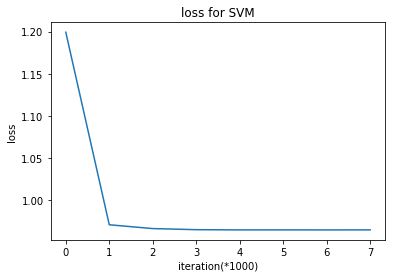

In [11]:
# loss for svm training, it converge a little slower
plt.plot(loss_svm_training[2:])
plt.xlabel("iteration(*1000)")
plt.ylabel("loss")
plt.title("loss for SVM")
plt.show()

In [12]:
R_validation = R[train_size:(train_size + validation_size)].reshape(-1,1)
R_test = R[-test_size:].reshape(-1,1)

In [13]:
# long if output is 1, short if output is -1
pnl_svm_validation = Y_predict_validation_svm * R_validation
pnl_svm_test = Y_predict_test_svm * R_test

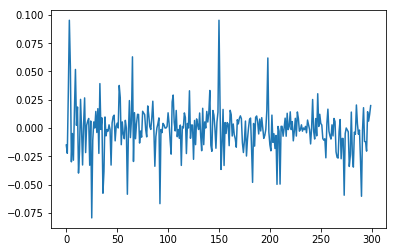

In [14]:
plt.plot(pnl_svm_validation)

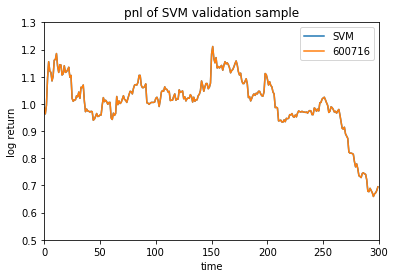

In [15]:
plt.plot(np.exp(np.cumsum(pnl_svm_validation)))
plt.plot(np.exp(np.cumsum(R_validation)))
plt.legend(("SVM","600716"))
plt.xlabel("time")
plt.ylabel("log return")
plt.xlim(0,300)
plt.ylim(0.5,1.3)
plt.title("pnl of SVM validation sample")
plt.show()

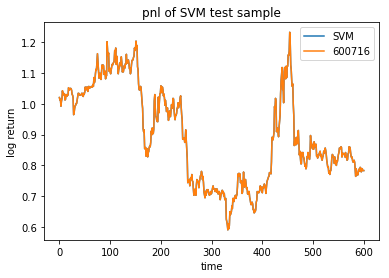

In [16]:
plt.plot(np.exp(np.cumsum(pnl_svm_test)))
plt.plot(np.exp(np.cumsum(R_test)))
plt.legend(("SVM","600716"))
plt.xlabel("time")
plt.ylabel("log return")
plt.title("pnl of SVM test sample")
plt.show()

In [17]:
class AutoEncoder_SVM:
    def __init__(self,n_input,n_output =1,hidden_layers=[25,15,10],regress_layer_shape = [10,10],\
                 l=0,learning_rate=0.01,activation_X=tf.nn.relu,activation_Y = tf.nn.sigmoid, optimizer = tf.train.AdamOptimizer):
        self.X = tf.placeholder("float", [None, n_input])
        self.Y = tf.placeholder("float", [None, n_output])
        
        self.hidden_layers = hidden_layers
        self.regress_layer_shape = regress_layer_shape
        
        # activation_X is for Auto-encoder part
        # activation_Y is for predicting returns
        self.activation = activation_X
        
        self.weight_encoder = [0] * 3
        self.weight_decoder = [0] * 3
        self.bias_encoder = [0] * 3
        self.bias_decoder = [0] * 3
        
        # define encoder weights
        self.weight_encoder[0] = tf.Variable(tf.random_normal([n_input, hidden_layers[0]]))
        self.weight_encoder[1] = tf.Variable(tf.random_normal([hidden_layers[0], hidden_layers[1]]))
        self.weight_encoder[2] = tf.Variable(tf.random_normal([hidden_layers[1], hidden_layers[2]]))
        
        # define decoder weights
        self.weight_decoder[0] = tf.Variable(tf.random_normal([hidden_layers[2], hidden_layers[1]]))
        self.weight_decoder[1] = tf.Variable(tf.random_normal([hidden_layers[1], hidden_layers[0]]))
        self.weight_decoder[2] = tf.Variable(tf.random_normal([hidden_layers[0], n_input]))
        
        # define bias_encoder
        self.bias_encoder[0] = tf.Variable(tf.random_normal([hidden_layers[0]]))
        self.bias_encoder[1] = tf.Variable(tf.random_normal([hidden_layers[1]]))
        self.bias_encoder[2] = tf.Variable(tf.random_normal([hidden_layers[2]]))
        
        # define bias_decoder
        self.bias_decoder[0] = tf.Variable(tf.random_normal([hidden_layers[1]]))
        self.bias_decoder[1] = tf.Variable(tf.random_normal([hidden_layers[0]]))
        self.bias_decoder[2] = tf.Variable(tf.random_normal([n_input]))
        
        # define encoder_optimazer
        encoder_op = self.encoder()
        decoder_op = self.decoder(encoder_op)
        
        self.x_predict = decoder_op
        self.x_true = self.X
        
        # mean square error loss
        self.loss_X = tf.reduce_mean(tf.square(self.x_true - self.x_predict)) 
        # self.loss_X = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(self.x_true,self.x_predict))
        
         ##SVM part
        A = tf.Variable(tf.random_normal(shape=[hidden_layers[-1], n_output]))
        b = tf.Variable(tf.random_normal(shape=[n_output, n_output]))

        self.model_output = tf.subtract(tf.matmul(encoder_op, A), b)

        l2_norm = tf.reduce_sum(tf.square(A))
        alpha = tf.constant([0.01])
        classification_term = tf.reduce_mean(tf.maximum(0., tf.subtract(1., tf.multiply(self.model_output, self.Y))))
        self.loss_Y = tf.add(classification_term, tf.multiply(alpha, l2_norm))
         # Declare prediction function, which returns +1/-1
        self.prediction = tf.sign(self.model_output)
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.prediction, self.Y), tf.float32))
        # we have a L1 regulariation for all the weight
        self.weight_encoder = np.array(self.weight_encoder)
        self.weight_decoder = np.array(self.weight_decoder)
        penalty = tf.constant(0.02)
        for i in range(len(self.weight_encoder)):
            penalty =tf.add(penalty, tf.reduce_mean(tf.abs(self.weight_encoder[i])))
            penalty = tf.add(penalty, tf.reduce_mean(tf.abs(self.weight_decoder[i])))
        self.penalty = tf.reduce_mean(penalty)
        self.loss_X = tf.add(self.loss_X, l * self.penalty)
        self.loss = tf.add(self.loss_X, self.loss_Y)
        #loss of predictions, which is equal to the loss of autoencoder part and neural network part.
        self.optimizer =  optimizer(learning_rate).minimize(self.loss)
        
    def encoder(self):
        layer = self.activation(tf.add(tf.matmul(self.X, self.weight_encoder[0]),self.bias_encoder[0]))
        layer = self.activation(tf.add(tf.matmul(layer, self.weight_encoder[1]),self.bias_encoder[1]))
        layer = self.activation(tf.add(tf.matmul(layer, self.weight_encoder[2]),self.bias_encoder[2]))
        return layer
    
    def decoder(self,Y):
        layer = self.activation(tf.add(tf.matmul(Y, self.weight_decoder[0]),self.bias_decoder[0]))
        layer = self.activation(tf.add(tf.matmul(layer, self.weight_decoder[1]),self.bias_decoder[1]))
        layer = self.activation(tf.add(tf.matmul(layer, self.weight_decoder[2]),self.bias_decoder[2]))
        return layer
    
    # define function "predict" to predict Y using encoder_op, which is the deepest inner layer
    def predict(self,X,n_input,n_output,activation):
        previous_layer_output = X
        previous_layer_size = n_input
        regress_layer_shape_full = self.regress_layer_shape + [n_output]
        # define all layers
        for i in range(0, len(regress_layer_shape_full)):
            if i < (len(regress_layer_shape_full) - 1):
                # inner (hidden) layer
                hidden_layer = core_layers.Dense(regress_layer_shape_full[i], activation=activation)   
            else:
                # output layer
                hidden_layer = core_layers.Dense(regress_layer_shape_full[i])
            hidden_layer.build([None, previous_layer_size])
            # output of a hidden layer is an iput to the next layer
            previous_layer_output = hidden_layer(previous_layer_output)
            
            # also redefine the size of the previous layer as the size of the current layer 
            previous_layer_size = regress_layer_shape_full[i]
        return previous_layer_output

In [18]:
model_autosvm =  AutoEncoder_SVM(n_input=X_train.shape[1],hidden_layers=[23,15,10],\
                      learning_rate=0.001,activation_X = tf.nn.sigmoid,l=0.02,optimizer=tf.train.AdamOptimizer)

In [19]:
# this iteration would take a little time
losses_auto_svm = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        _ = sess.run(model_autosvm.optimizer,feed_dict={model_autosvm.X:X_train,model_autosvm.Y:Y_train})
        loss,Y_predict_train,accuracy_train = sess.run((model_autosvm.loss,model_autosvm.prediction,model_autosvm.accuracy),\
                                                       feed_dict={model_autosvm.X:X_train,model_autosvm.Y:Y_train})
        if i%1000 == 0:
            print(i,loss,accuracy_train,end=" ")
            losses_auto_svm.append(loss)
    Y_predict_validation,accuracy_validation = sess.run((model_autosvm.prediction,model_autosvm.accuracy),\
                                            feed_dict={model_autosvm.X:X_validation,model_autosvm.Y:Y_validation})            
    Y_predict_test,accuracy_test = sess.run((model_autosvm.prediction,model_autosvm.accuracy),\
                                            feed_dict={model_autosvm.X:X_test,model_autosvm.Y:Y_test})

0 [637.5907] 0.49266666 1000 [629.0617] 0.49266666 2000 [628.8838] 0.49333334 3000 [628.81775] 0.49266666 4000 [628.7878] 0.49866667 5000 [628.7102] 0.56733334 6000 [628.6447] 0.5966667 7000 [628.6107] 0.612 8000 [628.5817] 0.62333333 9000 [628.5534] 0.63133335 

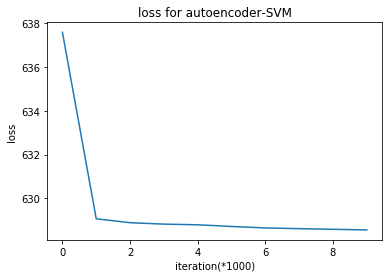

In [20]:
# loss for training sample with autoencoder with svm method
plt.plot(losses_auto_svm)
plt.xlabel("iteration(*1000)")
plt.ylabel("loss")
plt.title("loss for autoencoder-SVM")
plt.show()

In [21]:
pnl_validation_autosvm = Y_predict_validation * R_validation
pnl_test_autosvm = Y_predict_test * R_test

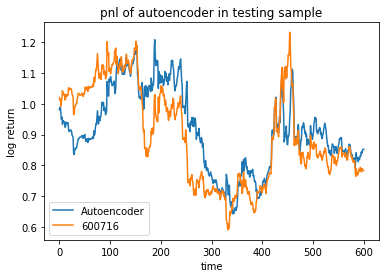

In [22]:
plt.plot(np.exp(np.cumsum(pnl_test_autosvm)))
plt.plot(np.exp(np.cumsum(R_test)))
plt.legend(("Autoencoder","600716"))
plt.xlabel("time")
plt.ylabel("log return")
plt.title("pnl of autoencoder in testing sample")
plt.show()

## Plot log return data predicted by AE and SVM and compare them to real data

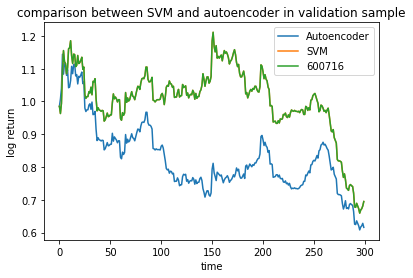

In [23]:
plt.plot(np.exp(np.cumsum(pnl_validation_autosvm)))
plt.plot(np.exp(np.cumsum(pnl_svm_validation)))
plt.plot(np.exp(np.cumsum(R_validation)))
plt.legend(("Autoencoder","SVM","600716"))
plt.xlabel("time")
plt.ylabel("log return")
plt.title("comparison between SVM and autoencoder in validation sample")
plt.show()

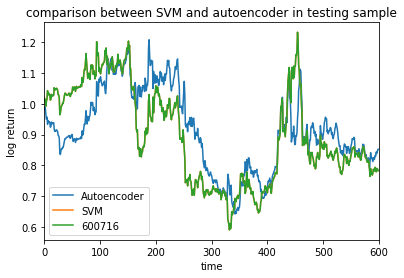

In [25]:
plt.plot(np.exp(np.cumsum(pnl_test_autosvm)))
plt.plot(np.exp(np.cumsum(pnl_svm_test)))
plt.plot(np.exp(np.cumsum(R_test)))
plt.legend(("Autoencoder","SVM","600716"))
plt.xlabel("time")
plt.xlim(0,600)
plt.ylabel("log return")
plt.title("comparison between SVM and autoencoder in testing sample")
plt.show()